In [1]:
import pickle 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

from hyperopt import hp, fmin, tpe, Trials

import io
import os
from PIL import Image

import json

In [2]:
df = pd.read_csv('../../data/day_ahead_energy_prices.csv', delimiter=",")[::-1]
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df.rename(columns={"hourly day-ahead energy price": "Price"}, inplace=True)
df



,Price
Datetime,
2024-11-21 23:00:00,107.46
2024-11-21 22:00:00,122.90
2024-11-21 21:00:00,123.05
2024-11-21 20:00:00,131.33
2024-11-21 19:00:00,154.05
...,...
2018-10-01 04:00:00,47.59
2018-10-01 03:00:00,47.38
2018-10-01 02:00:00,51.41


In [3]:

mix_df = pd.read_csv('../../data/hourly_market_mix_cleaned.csv', delimiter=",")[::-1]
mix_df.set_index("Timestamp", inplace=True)
mix_df.index = pd.to_datetime(mix_df.index)
mix_df.rename_axis("Datetime", inplace=True) 
mix_df = mix_df.loc[:, mix_df.max() >= 0.01]
mix_df

,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore
Datetime,,,,,,,,,,,
2024-10-30 00:00:00,0.101101,0.145455,0.045090,0.260219,0.243971,0.000000,0.049146,0.000022,0.0,0.047519,0.107476
2024-10-29 23:00:00,0.097725,0.149445,0.044872,0.274110,0.243789,0.000000,0.046156,0.000599,0.0,0.040935,0.102369
2024-10-29 22:00:00,0.095872,0.150584,0.047273,0.270704,0.255679,0.000000,0.046154,0.001140,0.0,0.035149,0.097447
2024-10-29 21:00:00,0.095560,0.150384,0.044436,0.265195,0.268427,0.000000,0.046835,0.002805,0.0,0.030024,0.096333
2024-10-29 20:00:00,0.093081,0.142999,0.047220,0.253702,0.278486,0.000000,0.044794,0.014459,0.0,0.027928,0.097331
...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01 04:00:00,0.092527,0.148990,0.019701,0.282126,0.146368,0.138012,0.040888,0.003391,0.0,0.045451,0.082545
2018-10-01 03:00:00,0.093932,0.146157,0.020071,0.286085,0.153114,0.140053,0.041441,0.003452,0.0,0.039751,0.075943
2018-10-01 02:00:00,0.094656,0.139489,0.020001,0.286402,0.161350,0.142441,0.041791,0.003471,0.0,0.038929,0.071471


In [4]:
# 天気データの読み込み
daily_weather_df = pd.read_csv('../../data/daily_weather.csv', delimiter=",")

# インデックスを 'date' 列に設定し、日付をパース
daily_weather_df.set_index('date', inplace=True)
daily_weather_df.index = pd.to_datetime(daily_weather_df.index)

# タイムゾーン情報を削除（必要に応じて）
daily_weather_df.index = daily_weather_df.index.tz_localize(None)

# 列名を統一（必要に応じてリネーム）
daily_weather_df.rename(columns={
    'Precipitation (rain/snow)': 'precipitation',
    'wind_speed_100m': 'wind_speed_80m',
    'Global Horizontal Irradiance': 'shortwave_radiation',
    'direct_radiation': 'direct_radiation',  # 既に同じ場合は不要
}, inplace=True)

# 必要に応じて他の列もリネーム


In [5]:
# 既存のデータフレームとのマージ
merged_df = pd.concat([df, mix_df, daily_weather_df], axis=1, join='inner')

# 欠損値の処理（必要に応じて）
merged_df.dropna(inplace=True)


In [6]:
TEST_SIZE = 0.18

SPLIT_DATE_EVAL = merged_df.index[int(TEST_SIZE * len(merged_df))]


train = merged_df.loc[merged_df.index < SPLIT_DATE_EVAL]
initial_test = merged_df.loc[merged_df.index >= SPLIT_DATE_EVAL]


test_eval_split = int(len(initial_test) / 2)

SPLIT_DATE_TEST = merged_df.index[int(TEST_SIZE * len(merged_df)) - test_eval_split - 1]

test = initial_test.iloc[:test_eval_split]
eval = initial_test.iloc[test_eval_split:]

eval

,Price,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,...,Wind onshore,temperature_2m,relative_humidity_2m,precipitation,surface_pressure,cloud_cover,wind_speed_80m,sunshine_duration,shortwave_radiation,direct_radiation
2024-05-04 16:00:00,63.62,0.096465,0.024743,0.055724,0.077814,0.148458,0.000000,0.044906,0.000021,0.496705,...,0.049590,14.057000,68.538980,0.0,977.62860,100.0,7.928177,0.0000,96.0,9.0
2024-05-04 15:00:00,26.03,0.087637,0.022742,0.051041,0.068759,0.134111,0.000000,0.041278,0.000114,0.549994,...,0.041963,14.557000,64.800110,0.0,978.26910,100.0,9.449572,0.0000,165.0,31.0
2024-05-04 14:00:00,13.34,0.084659,0.021921,0.049464,0.066149,0.127671,0.000000,0.039675,0.000313,0.569827,...,0.037794,15.007000,62.734380,0.1,978.80695,100.0,10.440000,1266.0848,318.0,73.0
2024-05-04 13:00:00,14.53,0.083514,0.021267,0.051857,0.068011,0.123663,0.000000,0.038848,0.000163,0.578401,...,0.028422,15.257000,59.870903,0.1,979.22360,100.0,8.891343,1188.6569,397.0,78.0
2024-05-04 12:00:00,24.93,0.083891,0.020784,0.049423,0.070333,0.123182,0.000000,0.038717,0.000161,0.579452,...,0.024030,15.157001,55.688720,0.0,979.69324,100.0,7.342588,1040.6843,360.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09 09:00:00,150.93,0.073774,0.159167,0.029291,0.192848,0.203637,0.041589,0.047585,0.022422,0.093772,...,0.130500,2.357000,90.469540,0.0,959.17395,100.0,10.086427,0.0000,102.0,0.0
2023-03-09 08:00:00,159.06,0.075664,0.161750,0.029668,0.200536,0.206469,0.042124,0.048324,0.041184,0.046613,...,0.140148,1.057000,94.735130,0.0,958.42377,100.0,4.024922,0.0000,42.0,0.0
2023-03-09 07:00:00,150.00,0.077839,0.163854,0.031833,0.215060,0.213201,0.043567,0.047938,0.030642,0.009541,...,0.158728,0.407000,96.443520,0.0,957.27810,100.0,3.259939,0.0000,18.0,0.0
2023-03-09 06:00:00,137.39,0.078203,0.154242,0.032481,0.223697,0.212995,0.045061,0.049149,0.014910,0.000225,...,0.178831,0.007000,96.783646,0.1,956.06964,100.0,5.116561,0.0000,0.0,0.0


In [7]:
merged_df["Price"].describe()


count    47304.000000
mean        94.206501
std        102.407993
min       -135.450000
25%         35.597500
50%         56.965000
75%        110.142500
max        871.000000
Name: Price, dtype: float64

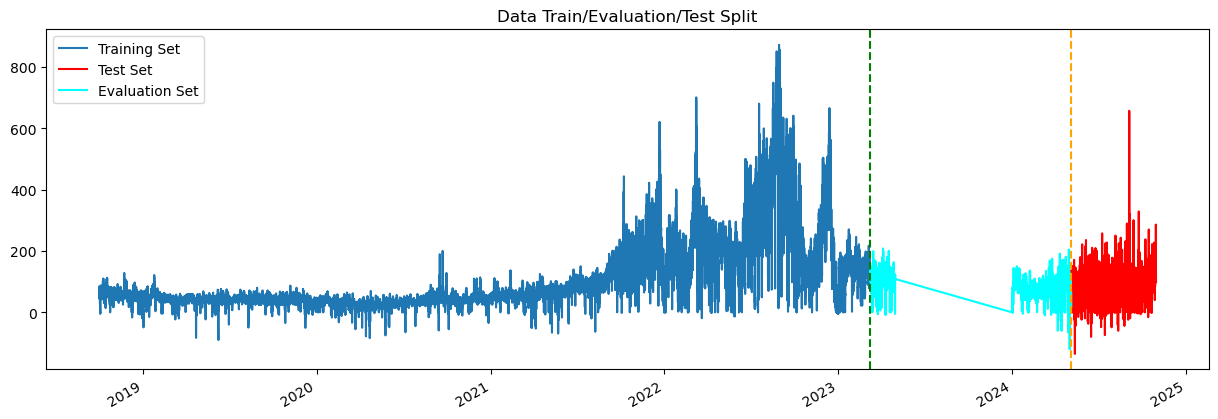

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))
train["Price"].plot(ax=ax, label='Training Set', title='Data Train/Evaluation/Test Split')
test["Price"].plot(ax=ax, label='Test Set', color="red")
eval["Price"].plot(ax=ax, label='Evaluation Set', color="cyan")
ax.axvline(SPLIT_DATE_EVAL, color='green', ls='--')
ax.axvline(SPLIT_DATE_TEST, color='orange', ls='--')
ax.legend(['Training Set', 'Test Set', 'Evaluation Set'])
plt.show()

In [9]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    for window in [3, 6, 12]: # hours
        df[f'ma_{int(window)}_hours'] = df['Price'].rolling(window=window).mean()
        df[f'biomass_ma_{int(window)}_hours'] = df['Biomass'].rolling(window=window).mean()
        df[f'pumped_storage_generation_ma_{int(window)}_hours'] = df['Pumped storage generation'].rolling(window=window).mean()
        df[f'hard_coal_ma_{int(window)}_hours'] = df['Hard Coal'].rolling(window=window).mean()
    
    for window in [24, 72, 168]:  # 1 day 3 days, and 1 week
        df[f'ma_{int(window / 24)}_days'] = df['Price'].rolling(window=window).mean()
        df[f'biomass_ma_{int(window / 24)}_days'] = df['Biomass'].rolling(window=window).mean()
        df[f'pumped_storage_generation_ma_{int(window / 24)}_days'] = df['Pumped storage generation'].rolling(window=window).mean()
        df[f'hard_coal_ma_{int(window / 24)}_days'] = df['Hard Coal'].rolling(window=window).mean()

    return df

### Feature Selection

In [10]:
train = create_features(train)
test = create_features(test)
eval = create_features(eval)

FEATURES = [
    "hour",
    "dayofyear",
    "dayofweek",
    "ma_3_hours",
    "ma_6_hours",
    "ma_1_days",
    "ma_3_days",
    "ma_7_days",
    "Biomass",
    "biomass_ma_3_hours",
    "biomass_ma_6_hours",
    "biomass_ma_1_days",
    "biomass_ma_3_days",
    "biomass_ma_7_days",
    "pumped_storage_generation_ma_3_hours",
    "pumped_storage_generation_ma_6_hours",
    "pumped_storage_generation_ma_1_days",
    "pumped_storage_generation_ma_3_days",
    "pumped_storage_generation_ma_7_days",
    "Hard Coal",
    "hard_coal_ma_3_hours",
    "hard_coal_ma_6_hours",
    "hard_coal_ma_1_days",
    "hard_coal_ma_3_days",
    "hard_coal_ma_7_days",
    "Hydro",
    "Lignite",
    "Natural Gas",
    "Nuclear",
    "Other",
    "Pumped storage generation",
    "Solar",
    "Wind offshore",
    "Wind onshore",
    # 天気データの特徴量を追加
    "temperature_2m",
    "relative_humidity_2m",
    "precipitation",
    "surface_pressure",
    "cloud_cover",
    "wind_speed_80m",
    "sunshine_duration",
    "shortwave_radiation",
    "direct_radiation",
]


TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

In [11]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    # 価格とエネルギーミックスの移動平均を計算
    for window in [3, 6, 12]:  # hours
        df[f'ma_{int(window)}_hours'] = df['Price'].rolling(window=window).mean()
        df[f'biomass_ma_{int(window)}_hours'] = df['Biomass'].rolling(window=window).mean()
        df[f'pumped_storage_generation_ma_{int(window)}_hours'] = df['Pumped storage generation'].rolling(window=window).mean()
        df[f'hard_coal_ma_{int(window)}_hours'] = df['Hard Coal'].rolling(window=window).mean()

    for window in [24, 72, 168]:  # days converted to hours
        df[f'ma_{int(window / 24)}_days'] = df['Price'].rolling(window=window).mean()
        df[f'biomass_ma_{int(window / 24)}_days'] = df['Biomass'].rolling(window=window).mean()
        df[f'pumped_storage_generation_ma_{int(window / 24)}_days'] = df['Pumped storage generation'].rolling(window=window).mean()
        df[f'hard_coal_ma_{int(window / 24)}_days'] = df['Hard Coal'].rolling(window=window).mean()

    # 天気データの移動平均（必要に応じて）
    weather_features = [
        'temperature_2m',
        'relative_humidity_2m',
        'precipitation',
        'surface_pressure',
        'cloud_cover',
        'wind_speed_80m',
        'sunshine_duration',
        'shortwave_radiation',
        'direct_radiation',
    ]

    for feature in weather_features:
        for window in [3, 6, 12]:
            df[f'{feature}_ma_{int(window)}_hours'] = df[feature].rolling(window=window).mean()
        for window in [24, 72, 168]:
            df[f'{feature}_ma_{int(window / 24)}_days'] = df[feature].rolling(window=window).mean()

    return df

# データセットに特徴量を適用
train = create_features(train)
test = create_features(test)
eval = create_features(eval)


### Auto ML

In [12]:
def objective(params):

    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['max_delta_step'] = int(params['max_delta_step'])
    params['early_stopping_rounds'] = int(params['early_stopping_rounds'])

    model = xgb.XGBRegressor(
        early_stopping_rounds=params['early_stopping_rounds'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        gamma=params['gamma'],
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        colsample_bynode=params['colsample_bynode'],
        colsample_bylevel=params['colsample_bylevel'],
        max_delta_step=params['max_delta_step'],
        reg_lambda=params['reg_lambda'],
        eval_metric='rmse',
        objective='reg:squarederror',
    )
    
    # Fit the model on the training data
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],  # Provide validation set for early stopping
        verbose=False  # Suppress training output
    )
    
    # Predict on the validation set
    predictions = model.predict(X_test)
    
    # Calculate the root mean squared error (RMSE)
    rmse = root_mean_squared_error(y_test, predictions)
    
    return rmse

In [13]:
search = True

search_space = {
    "early_stopping_rounds": hp.choice("early_stopping_rounds", np.arange(3, 300, 1, dtype=int)),
    "max_depth": hp.choice("max_depth", np.arange(30, 300, 1, dtype=int)),
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.5),
    "gamma": hp.uniform("gamma", 0, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0.7, 0.9),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "colsample_bynode": hp.uniform("colsample_bynode", 0.5, 1),
    "colsample_bylevel": hp.uniform("colsample_bylevel", 0.5, 1),
    "n_estimators": hp.choice("n_estimators", np.arange(100, 1000, 10, dtype="int")),
    "min_child_weight": hp.choice("min_child_weight", np.arange(1, 10, 1, dtype="int")),
    "max_delta_step": hp.choice("max_delta_step", np.arange(1, 10, 1, dtype="int")),
    "subsample": hp.uniform("subsample", 0.5, 1),
}

# Keeping track of the optimization history
trials = Trials()

if search:

    # Run the Hyperopt optimization
    best = fmin(
        fn=objective,  # Objective function
        space=search_space,  # Hyperparameter space
        algo=tpe.suggest,  # Optimization algorithm
        max_evals=50,  # Number of trials
        trials=trials,  # Store trials history
    )
# Display best parameters
print(f"early_stopping_rounds: {best['early_stopping_rounds']}, default: 10\n"
      f"max_depth: {best['max_depth']}, default: 6\n"
      f"learning_rate: {best['learning_rate']}, default: 0.3\n"
      f"n_estimators: {best['n_estimators']}, default: 100\n"
      f"gamma: {best['gamma']}, default: 0\n"
      f"min_child_weight: {best['min_child_weight']}, default: 1\n"
      f"subsample: {best['subsample']}, default: 1\n"
      f"colsample_bytree: {best['colsample_bytree']}, default: 1\n"
      f"colsample_bynode: {best['colsample_bynode']}, default: 1\n"
      f"colsample_bylevel: {best['colsample_bylevel']}, default: 1\n"
      f"max_delta_step: {best['max_delta_step']}, default: 0\n"
      f"reg_lambda: {best['reg_lambda']}, default: 1\n")


100%|██████████| 50/50 [35:14<00:00, 42.29s/trial, best loss: 14.776316907394708] 
early_stopping_rounds: 84, default: 10
max_depth: 177, default: 6
learning_rate: 0.25088619307811, default: 0.3
n_estimators: 23, default: 100
gamma: 0.11189964663042119, default: 0
min_child_weight: 7, default: 1
subsample: 0.6641991913548299, default: 1
colsample_bytree: 0.9821618402925899, default: 1
colsample_bynode: 0.8707263343114426, default: 1
colsample_bylevel: 0.8533087035487442, default: 1
max_delta_step: 8, default: 0
reg_lambda: 0.724054091704356, default: 1



In [14]:
    # Train the final model with the best hyperparameters on the full dataset
    final_model = xgb.XGBRegressor(
            early_stopping_rounds=best['early_stopping_rounds'],
            max_depth=best['max_depth'],
            learning_rate=best['learning_rate'],
            n_estimators=best['n_estimators'],
            gamma=best['gamma'],
            min_child_weight=best['min_child_weight'],
            subsample=best['subsample'],
            colsample_bytree=best['colsample_bytree'],
            colsample_bynode=best['colsample_bynode'],
            colsample_bylevel=best['colsample_bylevel'],
            max_delta_step=best['max_delta_step'],
            reg_lambda=best['reg_lambda'],
            # reg_alpha=best['reg_alpha'],
            eval_metric='rmse',
            objective='reg:squarederror',
    )

    final_model.fit(X_train, y_train,  eval_set=[(X_val, y_val)])

    # Predict on the test set or validation set
    final_predictions = final_model.predict(X_test)
    final_rmse = root_mean_squared_error(y_test, final_predictions)
    print("\n--- Final model RMSE:", final_rmse, "---")

[0]	validation_0-rmse:41.85858
[1]	validation_0-rmse:40.37422
[2]	validation_0-rmse:38.92911
[3]	validation_0-rmse:37.51703
[4]	validation_0-rmse:36.14085
[5]	validation_0-rmse:34.90216
[6]	validation_0-rmse:33.61021
[7]	validation_0-rmse:32.37662
[8]	validation_0-rmse:31.17888
[9]	validation_0-rmse:30.01830
[10]	validation_0-rmse:28.88746
[11]	validation_0-rmse:27.80164
[12]	validation_0-rmse:26.74950
[13]	validation_0-rmse:25.83174
[14]	validation_0-rmse:24.87149
[15]	validation_0-rmse:23.96419
[16]	validation_0-rmse:23.11888
[17]	validation_0-rmse:22.28799
[18]	validation_0-rmse:21.53273
[19]	validation_0-rmse:20.78052
[20]	validation_0-rmse:20.06993
[21]	validation_0-rmse:19.39923
[22]	validation_0-rmse:18.74127

--- Final model RMSE: 29.02782323898797 ---


## Final Model

In [15]:
update = True

best_params = {
    "base_score": np.float64(0.3888133835396405),
    "colsample_bytree": np.float64(0.6349243426308729),
    "early_stopping_rounds": np.int64(4),
    "gamma": np.float64(0.2753854688925828),
    "learning_rate": np.float64(0.05),
    "max_depth": np.int64(50),
    "min_child_weight": np.int64(7),
    "n_estimators": np.int64(200),
    "subsample": np.float64(0.5719023844219375),
}

if update:
    best_params = {
        "early_stopping_rounds": best['early_stopping_rounds'],
        "max_depth": best['max_depth'],
        "learning_rate": best['learning_rate'],
        "n_estimators": best['n_estimators'],
        "gamma": best['gamma'],
        "min_child_weight": best['min_child_weight'],
        "subsample": best['subsample'],
        "colsample_bytree": best['colsample_bytree'],
        "colsample_bynode": best['colsample_bynode'],
        "colsample_bylevel": best['colsample_bylevel'],
        "max_delta_step": best['max_delta_step'],
        "reg_lambda": best['reg_lambda'],
    }

print(
    f"early_stopping_rounds: {best_params['early_stopping_rounds']}, default: 10\n"
    f"max_depth: {best_params['max_depth']}, default: 6\n"
    f"learning_rate: {best_params['learning_rate']}, default: 0.3\n"
    f"n_estimators: {best_params['n_estimators']}, default: 100\n"
    f"gamma: {best_params['gamma']}, default: 0\n"
    f"min_child_weight: {best_params['min_child_weight']}, default: 1\n"
    f"subsample: {best_params['subsample']}, default: 1\n"
    f"colsample_bytree: {best_params['colsample_bytree']}, default: 1\n"
    f"colsample_bynode: {best_params['colsample_bynode']}, default: 1\n"
    f"colsample_bylevel: {best_params['colsample_bylevel']}, default: 1\n"
    f"max_delta_step: {best_params['max_delta_step']}, default: 0\n"
    f"reg_lambda: {best_params['reg_lambda']}, default: 1\n"
)

# print(dict(best_params))

reg = xgb.XGBRegressor(**best_params)

reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=25)

early_stopping_rounds: 84, default: 10
max_depth: 177, default: 6
learning_rate: 0.25088619307811, default: 0.3
n_estimators: 23, default: 100
gamma: 0.11189964663042119, default: 0
min_child_weight: 7, default: 1
subsample: 0.6641991913548299, default: 1
colsample_bytree: 0.9821618402925899, default: 1
colsample_bynode: 0.8707263343114426, default: 1
colsample_bylevel: 0.8533087035487442, default: 1
max_delta_step: 8, default: 0
reg_lambda: 0.724054091704356, default: 1

[0]	validation_0-rmse:41.85858
[22]	validation_0-rmse:18.74127


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8533087035487442,
             colsample_bynode=0.8707263343114426,
             colsample_bytree=0.9821618402925899, device=None,
             early_stopping_rounds=84, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.11189964663042119,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.25088619307811,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=8, max_depth=177, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=23, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

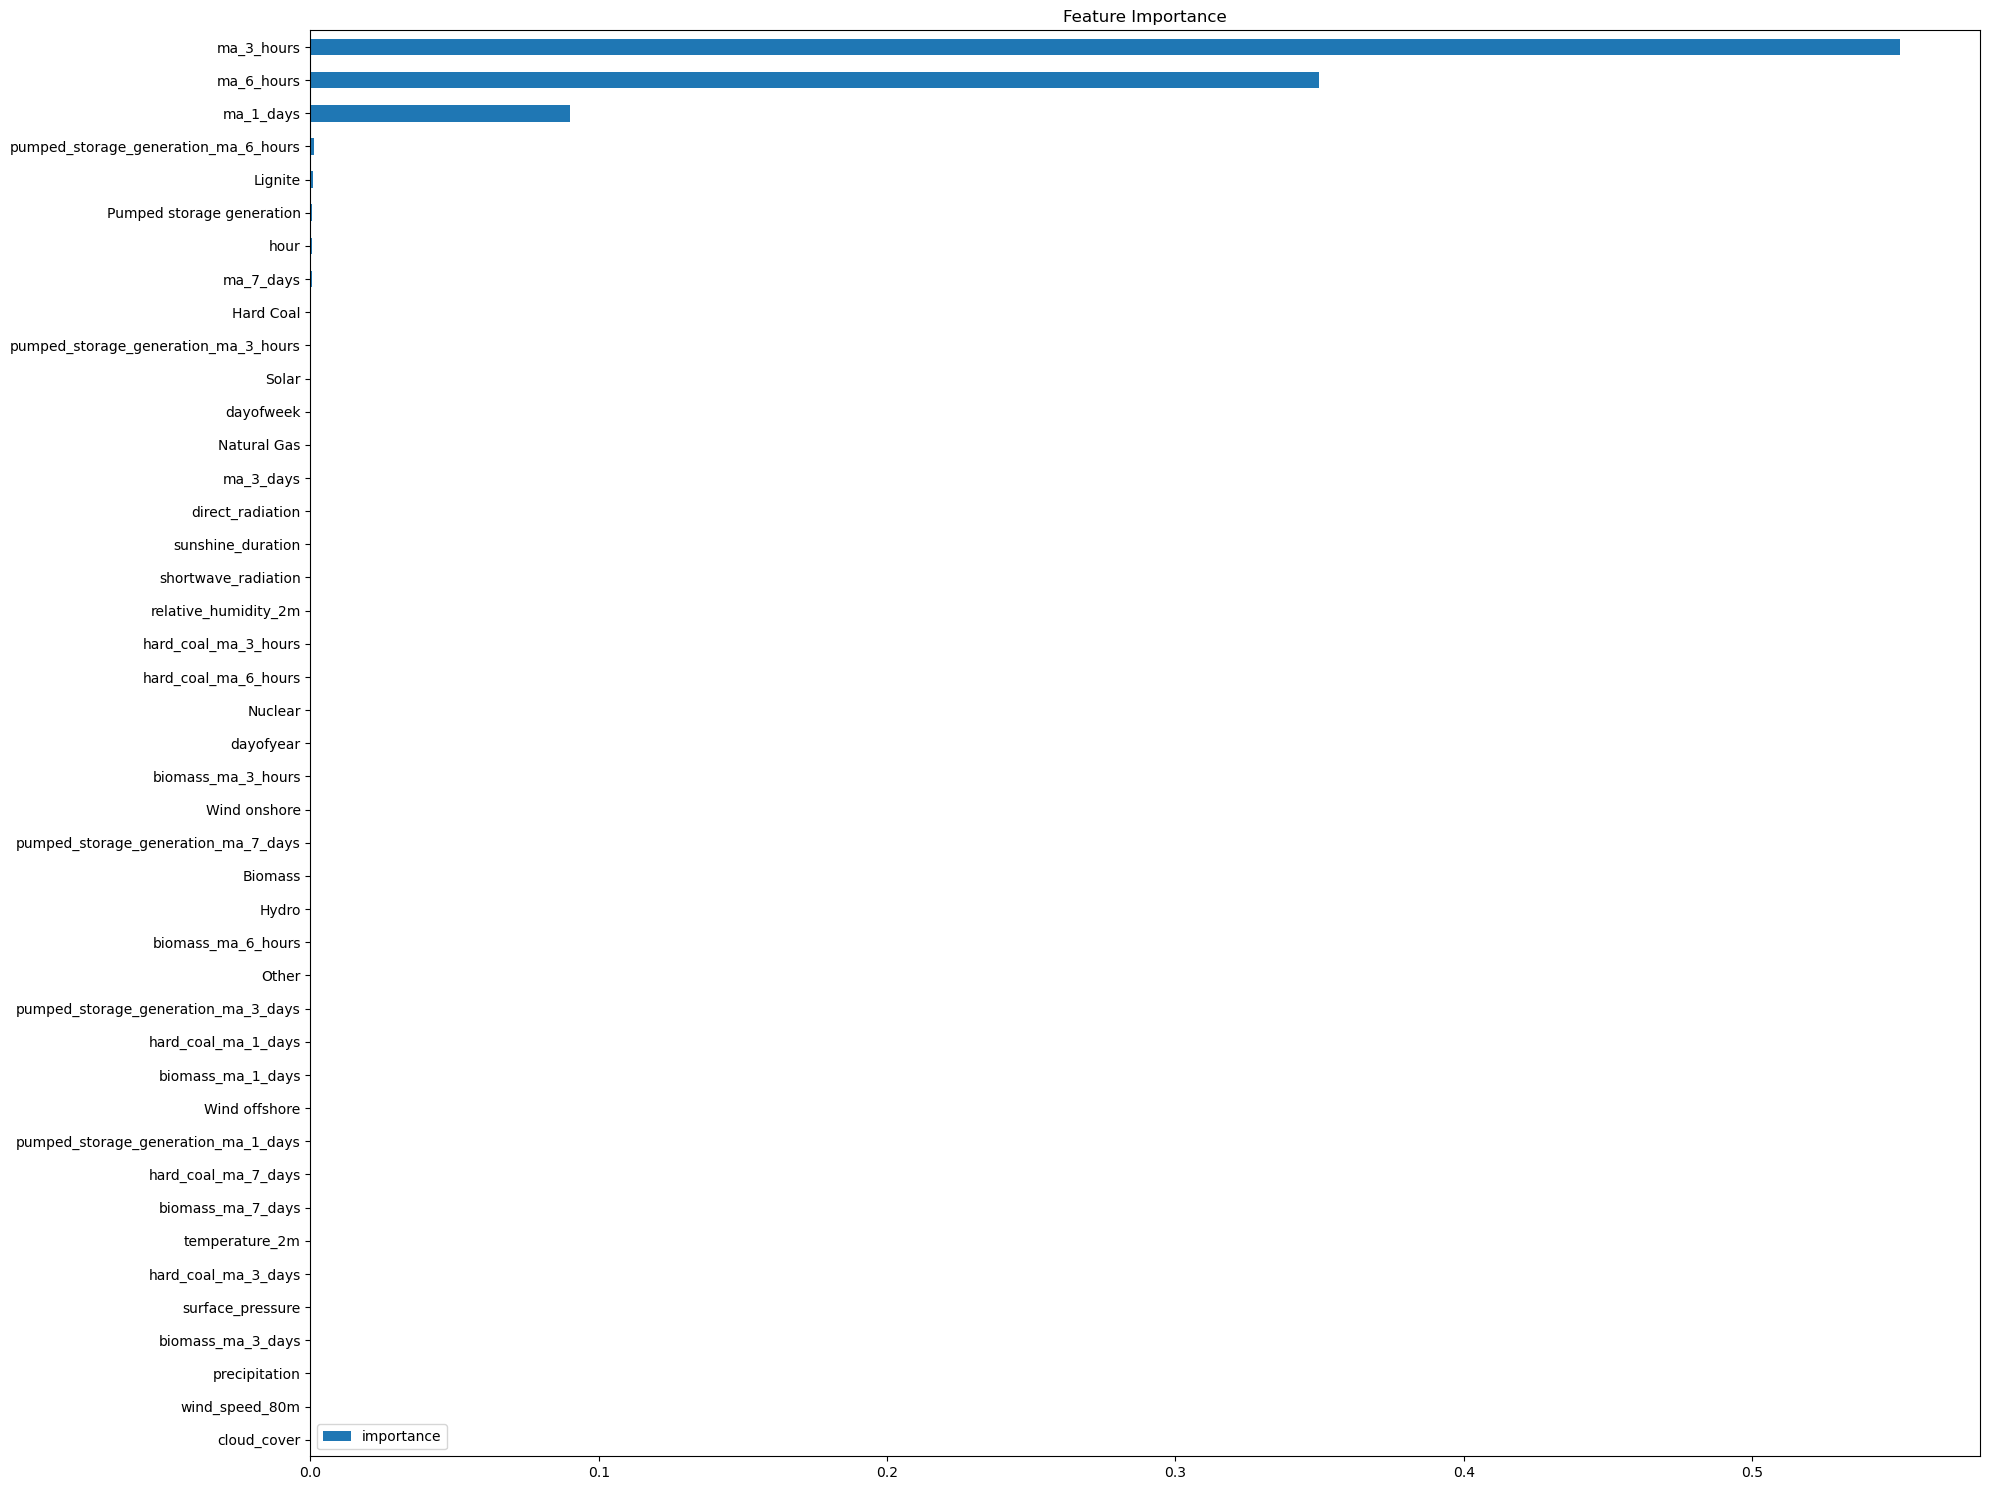

In [16]:
# plt.figure(figsize=(30, 20))
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'], )
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(20, 15))
plt.tight_layout()
buf = io.BytesIO()
plt.savefig(buf, format='png')
plt.show()
plt.close()
buf.seek(0)

feature_importance_image = Image.open(buf)

In [17]:
test['prediction'] = reg.predict(X_test)
prediction_df = merged_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [18]:
#test error fot the entire test set
score = root_mean_squared_error(test[TARGET], test['prediction'])
print(f'RMSE Score on Test set: {score:.2f}')

RMSE Score on Test set: 29.03


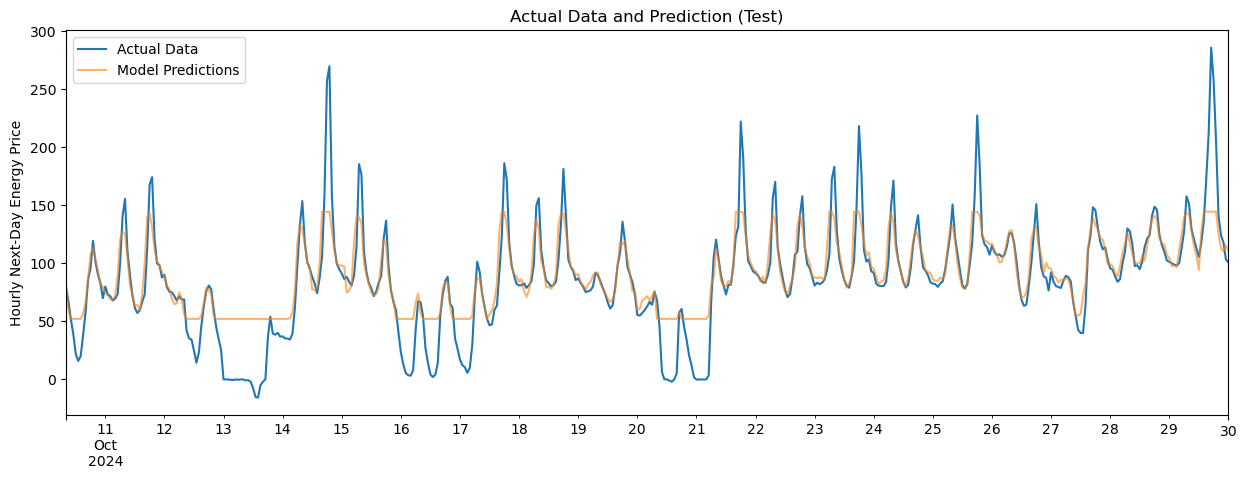

In [19]:

WINDOW = prediction_df.iloc[:int(0.01 * (len(prediction_df)))].copy()

ax = WINDOW[[TARGET]].plot(figsize=(15, 5))
prediction_df['prediction'].plot(ax=ax, style='-', alpha=0.6)
ax.set_xlim(WINDOW.index.min(), WINDOW.index.max())
ax.set_ylabel("Hourly Next-Day Energy Price")
plt.legend(['Actual Data', 'Model Predictions'])    
ax.set_title('Actual Data and Prediction (Test)')

buf = io.BytesIO()
plt.savefig(buf, format='png')
plt.show()
plt.close()
buf.seek(0)

ts_image = Image.open(buf)

### Average absolute error by day

In [20]:
test['error'] = np.abs(test[TARGET] - prediction_df['prediction'])
test['date'] = test.index.date
test['error'].groupby(test['date']).mean()

date
2024-05-04     9.008905
2024-05-05    19.962827
2024-05-06     6.437047
2024-05-07     6.100146
2024-05-08     4.605049
                ...    
2024-10-26     6.656366
2024-10-27     6.923292
2024-10-28     5.624709
2024-10-29    23.608224
2024-10-30     9.695296
Name: error, Length: 180, dtype: float64

### Specific Date Predictions

In [ ]:
date = '2024-10-29'
predictions = prediction_df.loc[date, 'prediction']

# Display the result
print(predictions)

2024-10-29 23:00:00    115.527573
2024-10-29 22:00:00    110.328278
2024-10-29 21:00:00    112.707367
2024-10-29 20:00:00    125.008842
2024-10-29 19:00:00    144.454575
2024-10-29 18:00:00    144.454575
2024-10-29 17:00:00    144.454575
2024-10-29 16:00:00    144.454575
2024-10-29 15:00:00    144.454575
2024-10-29 14:00:00    144.454575
2024-10-29 13:00:00    126.853630
2024-10-29 12:00:00     94.198166
2024-10-29 11:00:00    106.775734
2024-10-29 10:00:00    115.285751
2024-10-29 09:00:00    127.448509
2024-10-29 08:00:00    142.781021
2024-10-29 07:00:00    142.805374
2024-10-29 06:00:00    140.220749
2024-10-29 05:00:00    124.956650
2024-10-29 04:00:00    111.099525
2024-10-29 03:00:00     96.523666
2024-10-29 02:00:00     98.120605
2024-10-29 01:00:00     97.557747
2024-10-29 00:00:00    104.228607
Name: prediction, dtype: float32


In [22]:
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f'./pickle/model_{score: .4g}_rmse_{ts}'
os.makedirs(output_dir, exist_ok=True)

model_dump_path = os.path.join(output_dir, "model.pickle")
with open(model_dump_path, "wb") as file:
    pickle.dump(reg, file)
hp_path = os.path.join(output_dir, "hyperparams.json")
with open(hp_path, "w") as file:
    best_params_native = {k: (int(v) if isinstance(v, (np.integer, int)) else float(v) if isinstance(v, (np.floating, float)) else v) for k, v in best_params.items()}
    json.dump(best_params_native, file, indent=4)
output_filename = 'plot_image.png'
ts_chart_path = os.path.join(output_dir, output_filename)
ts_image.save(ts_chart_path)

output_filename = 'feature_importance.png'
fi_path = os.path.join(output_dir, output_filename)
feature_importance_image.save(fi_path)

save models pickel
add 500 to axis -> z-standardisation might also work
features?
register

